A telecom company faces rising customer departures. They currently use a reactive approach, only responding when customers initiate cancellation.

The company needs to shift to a proactive strategy by leveraging customer data to predict which customers might leave and why, allowing for timely, targeted interventions before customers decide to switch providers.

The goal is to reduce churn rates and preserve revenue through data-driven retention efforts by creating a model that can predict customers who are at risk of leaving.


In [3]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   --- ------------------------------------ 9.7/124.9 MB 60.1 MB/s eta 0:00:02
   ------- -------------------------------- 22.3/124.9 MB 64.0 MB/s eta 0:00:02
   ------------ --------------------------- 37.5/124.9 MB 64.3 MB/s eta 0:00:02
   ---------------- ----------------------- 52.2/124.9 MB 66.4 MB/s eta 0:00:02
   -------------------- ------------------- 63.7/124.9 MB 63.4 MB/s eta 0:00:01
   ------------------------- -------------- 78.9/124.9 MB 64.5 MB/s eta 0:00:01
   ----------------------------- ---------- 92.8/124.9 MB 65.8 MB/s eta 0:00:01
   --------------------------------- ----- 108.0/124.9 MB 66.3 MB/s eta 0:00:01
   ------------------------------------- - 121.4/124.9 MB 66.2 MB/s eta 0:00:01
   --------------------------------------  124.8/124.9 MB 66.4 MB/s eta 0:00:01
   ---------------------------------------- 124.9/124.9 MB 59.5 MB/s  0:00:02


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

# Load dataset
df = pd.read_csv("churn.csv")

# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

**Observations on Data**

- need to explore Dtype object to determine if conversion is needed
- need to convert churn to int

In general, pre-processing should occur _after_ train test splitting to avoid data leakage.

In [5]:
# Define features and target variable
X = df.drop(columns=['churn'])  # Assuming 'Churn' is the target variable
y = df['churn']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [7]:
# Fit and transform on training data
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Convert encoded arrays to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, index=X_train.index, columns=encoder.get_feature_names_out(categorical_cols))
X_test_encoded_df = pd.DataFrame(X_test_encoded, index=X_test.index, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded features
X_train = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded_df], axis=1)

c:\Users\marha\.conda\envs\ml\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**One-hot encoding** prevents the model from treating categorical variables as ordinal.

Stratified splitting ensures both training and testing sets have the same proportion of "churn" and "non-churn" customers.

**Key Questions**

- Are there irrelevant or highly correlated features that should be removed?
- Should feature scaling be applied? (Not required for tree-based models like Random Forest and Boosting.)

Random Forest Model Performance:
              precision    recall  f1-score   support

       False       0.88      1.00      0.94       570
        True       0.92      0.24      0.38        97

    accuracy                           0.89       667
   macro avg       0.90      0.62      0.66       667
weighted avg       0.89      0.89      0.86       667



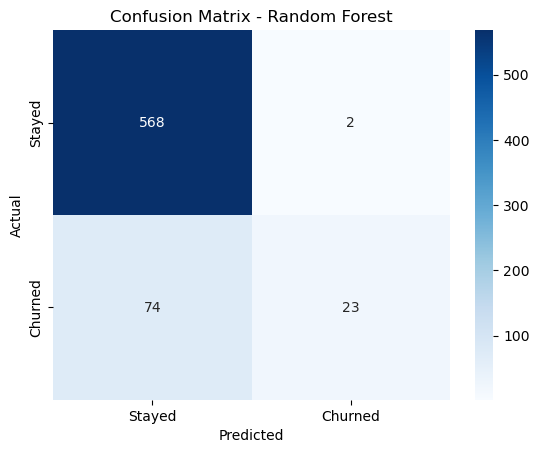

In [8]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

**Key Questions**

- If accuracy is low, should we increase the number of trees (n_estimators) or tune other hyperparameters, or move to a more complex model?
- High accuracy is expected to the class imbalance, better looking at F1, Precision, or Recall.

#### AdaBoost Model ####

AdaBoost Model Performance:
              precision    recall  f1-score   support

       False       0.87      0.99      0.92       570
        True       0.59      0.10      0.18        97

    accuracy                           0.86       667
   macro avg       0.73      0.55      0.55       667
weighted avg       0.83      0.86      0.81       667



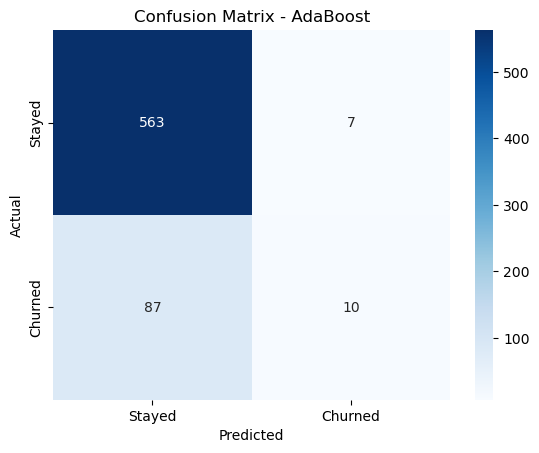

In [9]:
# Train AdaBoost model
adaboost_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
adaboost_model.fit(X_train, y_train)

# Make predictions
y_pred_ada = adaboost_model.predict(X_test)

# Evaluate AdaBoost model
print("AdaBoost Model Performance:")
print(classification_report(y_test, y_pred_ada))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_ada)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

**Notes**

- AdaBoost assigns higher weights to misclassified instances to correct errors
- Effective with smaller datasets, training can be slow

#### Gradient Boosting Model ####

Gradient Boosting Model Performance:
              precision    recall  f1-score   support

       False       0.94      0.99      0.96       570
        True       0.88      0.60      0.71        97

    accuracy                           0.93       667
   macro avg       0.91      0.79      0.84       667
weighted avg       0.93      0.93      0.92       667



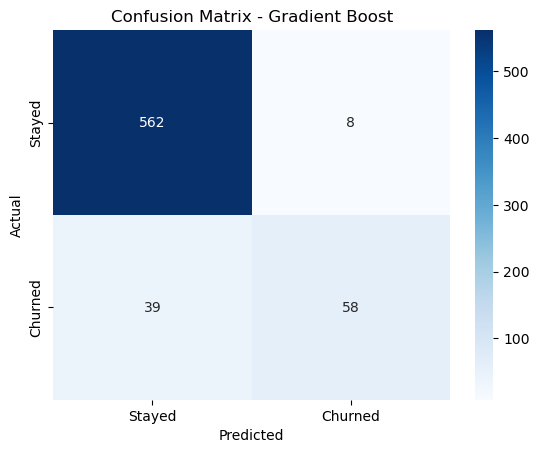

In [10]:
# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate Gradient Boosting model
print("Gradient Boosting Model Performance:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boost')
plt.show()

**Notes**

- Uses gradient descent to optimize for errors; more complex than AdaBoost but more accurate
- Performance without tuning is better than AdaBoost

#### XGBoost Model ####

c:\Users\marha\.conda\envs\ml\lib\site-packages\xgboost\core.py:158: UserWarning: [12:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Performance:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       570
        True       0.88      0.67      0.76        97

    accuracy                           0.94       667
   macro avg       0.91      0.83      0.86       667
weighted avg       0.94      0.94      0.94       667



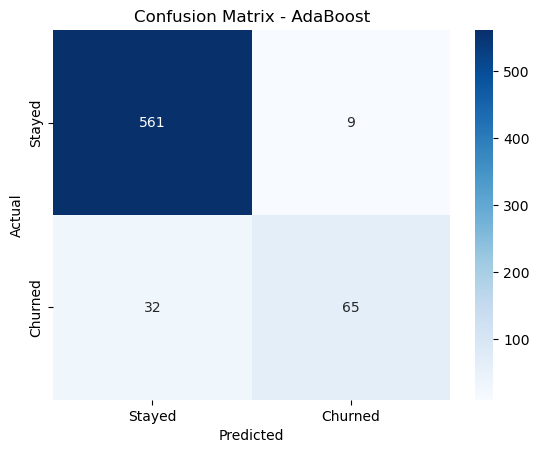

In [11]:
# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)


# Make predictions
y_pred_xgb = xgb_model.predict(X_test)


# Evaluate XGBoost model
print("XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

**Notes**

- XGBoost is an optimized version of Gradient Boosting; runs faster and prevents overfitting
- Better results without tuning

#### Hyperparameter Tuning ####

In [12]:
# Define parameter grid, keep max depth low (weak learners)
# More estimators means longer time needed to train
param_grid = {'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.05, 0.1],
'max_depth': [3, 5, 7]}

# Instanstiate GridSearch and select metric to score
grid_search = GridSearchCV(xgb_model, 
                           param_grid, 
cv=5, 
scoring='accuracy', 
n_jobs=-1)

# Fit model to train
grid_search.fit(X_train, y_train)

# Evaluate GS results
print("Best parameters from grid search:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Best training score: {grid_search.best_estimator_.score(X_train, y_train):.3f}")

c:\Users\marha\.conda\envs\ml\lib\site-packages\xgboost\core.py:158: UserWarning: [12:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters from grid search:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.958
Best training score: 0.981


#### Final Predictions on Test Data ####

Final Model Accuracy: 0.95
Final Model Performance Report:
              precision    recall  f1-score   support

       False       0.95      0.98      0.97       570
        True       0.89      0.72      0.80        97

    accuracy                           0.95       667
   macro avg       0.92      0.85      0.88       667
weighted avg       0.94      0.95      0.94       667



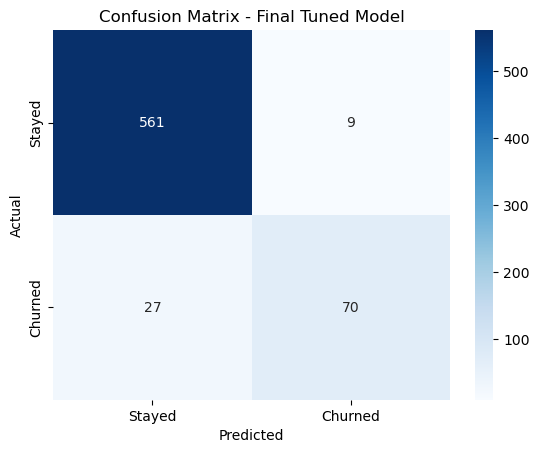

In [13]:
# Extract best/final model
best_xgb = grid_search.best_estimator_


# Make final predictions on the test set
y_pred_final = best_xgb.predict(X_test)


# Evaluate final model performance
accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Model Accuracy: {accuracy:.2f}")


# Display classification report
print("Final Model Performance Report:")
print(classification_report(y_test, y_pred_final))


# Generate final confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Tuned Model')
plt.show()

#### Insights from the Model ####

Model performance on churn:

- If the model has high recall for "churn" cases, it means it correctly identifies most customers who are likely to leave.
- If the model has high precision for "churn" cases, it means the predicted churn cases are very likely to be actual churners.

Business owner actions:

- If a high-risk churn customer is detected, the company can send personalized retention offers.
- If misclassified customers (false positives) are too high, resources may be wasted on customers unlikely to churn.
- If false negatives are high, the business risks losing customers who could have been retained.

##### What Features Are Driving Churn? #####

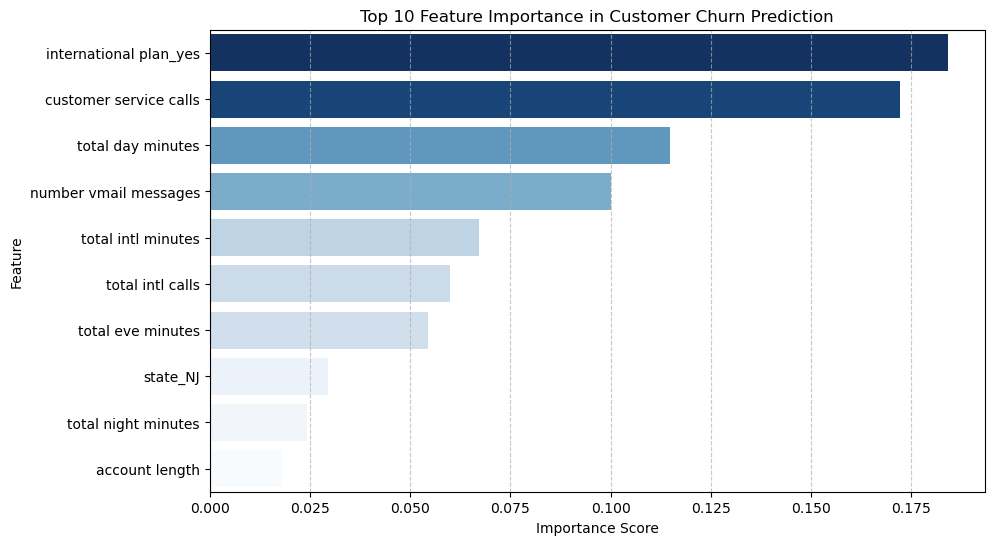

In [14]:
# Sort features by importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_xgb.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


# Select only the top 10 most important features
top_features = feature_importance.head(10)


# Set figure size
plt.figure(figsize=(10, 6))


# Create horizontal bar plot for better readability
sns.barplot(y=top_features['Feature'], x=top_features['Importance'], palette="Blues", hue=top_features['Importance'], legend=False)


# Adjust labels and title
plt.title('Top 10 Feature Importance in Customer Churn Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid for readability


plt.show()

#### Insights & Recommendations ####

These features are the largest drivers of customer churn, in decreasing order of importance:

- International Plan (international plan_yes): customers with an international plan are more likely to churn. 
    - This could indicate dissatisfaction with international call rates or service quality.
- Customer Service Calls: high customer service interactions suggest that dissatisfied customers are calling for support before deciding to leave.
    - Addressing these issues proactively may reduce churn.
- Total Day Minutes: customers who use more daytime minutes tend to churn, possibly due to high costs or better deals elsewhere.
- Voicemail Messages: high voicemail usage correlates with churn, potentially indicating missed calls due to service disruptions.
- International Calls & Minutes: frequent international communication is another churn indicator, reinforcing the issue with international plans.
- State-Specific Trends: New Jersey shows higher churn rates, which may indicate regional service issues or competitor influence.

**Recommendations**

- Review & improve international plans
- Enhance customer support for high-frequency callers
- Explore competitor offers and consider retention deals
- Additional analysis for high-churn states